### Entrenamiento del modelo

In [46]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [47]:
# Cargar el dataset
df = pd.read_csv('daily_occupancy.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')
df.set_index('fecha', inplace=True)

# Variable objetivo
y = df['ocupacion']

# Variables exógenas
# X = df.drop(columns=['ocupacion'])
exog_cols = ['dia_festivo', 'lag_1', 'lag_2', 'lag_4']
X = df[exog_cols]

# Revisión rápida
print(X.head())
print(y.head())

            dia_festivo   lag_1   lag_2   lag_4
fecha                                          
2019-02-13            0     0.0     0.0     0.0
2019-02-14            0  1006.0     0.0     0.0
2019-02-15            0  1121.0  1006.0     0.0
2019-02-16            0  1249.0  1121.0     0.0
2019-02-17            0  1251.0  1249.0  1006.0
fecha
2019-02-13    1006
2019-02-14    1121
2019-02-15    1249
2019-02-16    1251
2019-02-17     912
Name: ocupacion, dtype: int64


In [48]:
# Split train/test para y y X
horizonte = 30
y_train = y.iloc[:-horizonte]
y_test = y.iloc[-horizonte:]
X_train = X.iloc[:-horizonte]
X_test = X.iloc[-horizonte:]

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(365,) (365, 4)
(30,) (30, 4)


In [49]:
order = (0, 0, 2) # p, d, q
seasonal_order = (1, 0, 1, 7) 

# Ajustar el modelo SARIMAX
modelo_exog = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
modelo_exog_fit = modelo_exog.fit(disp=False)

print(modelo_exog_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           ocupacion   No. Observations:                  365
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2354.447
Date:                             Wed, 21 May 2025   AIC                           4728.893
Time:                                     15:52:19   BIC                           4767.415
Sample:                                 02-13-2019   HQIC                          4744.230
                                      - 02-12-2020                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dia_festivo   -98.5524     85.030     -1.159      0.246    -265.209      68.104
lag_1           1.1692  

MAE: 55.25
MPE: 5.81%
RMSE: 71.40


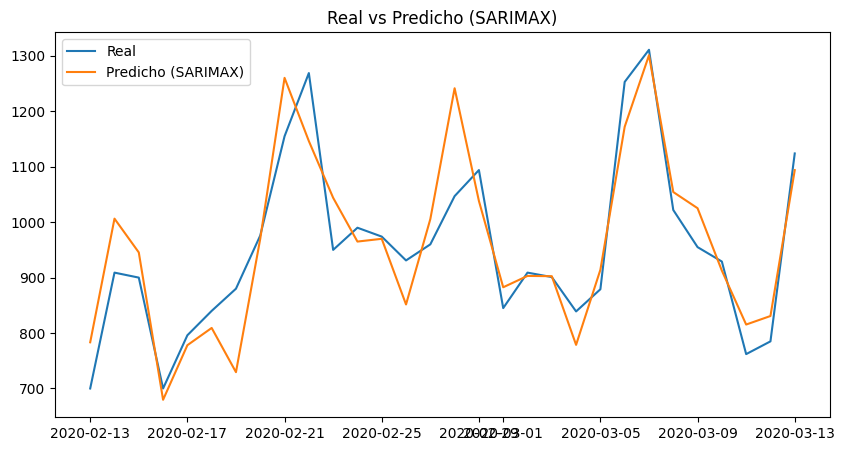

In [50]:
# Predecir los próximos 30 días
predicciones_exog = modelo_exog_fit.forecast(steps=30, exog=X_test)
predicciones_exog.index = y_test.index  # Para que los índices coincidan

# Cálculo de métricas
mae = mean_absolute_error(y_test, predicciones_exog)
mpe = ((y_test - predicciones_exog) / y_test).abs().mean() * 100
rmse = root_mean_squared_error(y_test, predicciones_exog)

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real')
plt.plot(predicciones_exog, label='Predicho (SARIMAX)')
plt.title('Real vs Predicho (SARIMAX)')
plt.legend()
plt.savefig('sarimax_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### Se uploadea el modelo (parámetros y métricas) al **MLFlow**

In [51]:
# Set tracking URI and experiment
import mlflow.statsmodels


mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Log params, metrics, insights.
# Infer signature
signature = infer_signature(X_train, modelo_exog_fit.forecast(steps=30, exog=X_test))

# Log with MLflow
with mlflow.start_run():    
    # Parametros del modelo
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_param("horizonte", horizonte)
    mlflow.log_param("exog_cols", exog_cols)
    mlflow.log_param("enforce_stationarity", False)
    mlflow.log_param("enforce_invertibility", False)

    # Métricas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MPE", mpe)
    mlflow.log_metric("RMSE", rmse)

    # Artifactos
    mlflow.log_artifact("sarimax_forecast.png", artifact_path="plots")

    # registrar modelo
    mlflow.statsmodels.log_model(modelo_exog_fit, "model", 
                                registered_model_name="SARIMAX", 
                                signature=signature)

2025/05/21 15:52:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'SARIMAX' already exists. Creating a new version of this model...
2025/05/21 15:52:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SARIMAX, version 5
Created version '5' of model 'SARIMAX'.


🏃 View run stately-elk-441 at: http://localhost:5001/#/experiments/176230793224478268/runs/5ff3f4abd8c84d6f824c3e6150d633a1
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268
